In [1]:
from pathlib import Path
import os
import glob

import pandas as pd
import numpy as np
import math
import re
import copy
import urllib.request
import json
from scipy.interpolate import splprep, splev

import matplotlib.pyplot as plt
import pygmaps

# Detect stay point

In [2]:
dc=50
tc=30

In [3]:
def read_files(files):
    data = pd.DataFrame()
    
    trajTem=pd.read_csv(files,sep=',',skiprows=1,header=None) 
    trajTem=trajTem.iloc[:,[1,2,3]] #read Datetime. latitude, and longitude
    trajTem.columns=['DateTime','Latitude','Longitude']
    data=data.append(trajTem,ignore_index=True)
    
    dateTime=list(data['DateTime'])

    year=[];month=[];day=[];hour=[];minute=[];second=[]
    for i in range(len(data)): #extract date and time info 
        dateTime_S = str(dateTime[i])
        year.append(int(dateTime_S[0:4]))
        month.append(int(dateTime_S[4:6]))
        day.append(int(dateTime_S[6:8]))
        hour.append(int(dateTime_S[8:10]))
        minute.append(int(dateTime_S[10:12]))
        second.append(int(dateTime_S[12:14]))
    
                
    
    data['year']=year;data['month']=month;data['day']=day;data['hour']=hour;data['minute']=minute;data['second']=second
    data=data.drop(['DateTime'],axis=1)
        
    return data

In [4]:
def rad(d):
    return float(d) * math.pi/180.0


EARTH_RADIUS=6378.137
def GetDistance(lng1,lat1,lng2,lat2):
    radLat1 = rad(lat1);
    radLat2 = rad(lat2);
    a = radLat1 - radLat2;
    b = rad(lng1) - rad(lng2);
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2),2) +math.cos(radLat1)*math.cos(radLat2)*math.pow(math.sin(b/2),2)))
    s = s * EARTH_RADIUS;
    s = round(s * 10000,2) / 10;
    return s

In [5]:
def density(data,dc):
    latitude=list(data['Latitude'])
    longitude=list(data['Longitude'])
    part_density=[]   #local density
    scope=[] 
    leftBoundary=0;rightBoundary=len(data)-1
    for i in range(len(data)):
        traigger=True
        left=i-1
        right=i+1
        incrementLeft=1;incrementRight=1 
        while traigger:
            #Left
            if incrementLeft!=0:                
                if left<0:
                    left=leftBoundary
                distanceLeft=GetDistance(longitude[left],latitude[left],longitude[i],latitude[i])
                if (distanceLeft<dc)&(left>leftBoundary):
                    left-=1
                else:
                    incrementLeft=0
            #Right
            if incrementRight!=0:                
                if right>rightBoundary:
                    right=rightBoundary                            
                distanceRight=GetDistance(longitude[i],latitude[i],longitude[right],latitude[right])
                if (distanceRight<dc)&(right<rightBoundary):
                    right+=1
                else:
                    incrementRight=0
            #Stop
            if (incrementLeft==0)&(incrementRight==0):
                traigger=False
            if (left==leftBoundary)&(incrementRight==0):
                traigger=False
            if (incrementLeft==0)&(right==rightBoundary):
                traigger=False
        if left==leftBoundary:
            scope.append([left,right-1])
            part_density.append(right-left-1)
        elif right==rightBoundary:
            scope.append([left+1,right])
            part_density.append(right-left-1)
        else:
            scope.append([left+1,right-1])
            part_density.append(right-left-2)
    return part_density,scope

In [6]:
#Reverse
def SP_search(data,tc):
    SP=[]
    part_density=copy.deepcopy(list(data['part_density']))
    scope=copy.deepcopy(list(data['scope']))
    day=copy.deepcopy(list(data['day']))
    hour=copy.deepcopy(list(data['hour']))
    minute=copy.deepcopy(list(data['minute']))
    second=copy.deepcopy(list(data['second']))
    latitude=copy.deepcopy(list(data['Latitude']))
    longitude=copy.deepcopy(list(data['Longitude']))
    traigger=True
    used=[]
    while traigger:
        partD=max(part_density)
        index=part_density.index(partD)
#         print('index:',index)

        start=scope[index][0];end=scope[index][1]
        if len(used)!=0:
            for i in used:
                if (scope[i][0]>start)&(scope[i][0]<end):
                    part_density[index]=scope[i][0]-start-1
                    scope[index][1]=scope[i][0]-1
#                     print("1_1")
                if (scope[i][1]>start)&(scope[i][1]<end):
                    part_density[index]=end-scope[i][1]-1
                    scope[index][0]=scope[i][1]+1
#                     print("1_2")
                if (scope[i][0]<=start)&(scope[i][1]>=end):
                    part_density[index]=0
                    scope[index][0]=0;scope[index][1]=0
#                     print("1_3")
            start=scope[index][0];end=scope[index][1]
        timeCross=86400*(day[end]-day[start])+3600*(hour[end]-hour[start])+60*(minute[end]-minute[start])+(second[end]-second[start])
#         print('time:',timeCross)

        if timeCross>tc:
            SarvT=str(day[start])+' '+str(hour[start])+':'+str(minute[start])+':'+str(second[start])
            SlevT=str(day[end])+' '+str(hour[end])+':'+str(minute[end])+':'+str(second[end])
            SP.append([index,latitude[index],longitude[index],SarvT,SlevT,scope[index]])
            used.append(index)
            for k in range(scope[index][0],scope[index][1]+1):
                part_density[k]=0
        part_density[index]=0
        if max(part_density)==0:
            traigger=False
    return SP

In [7]:
def similar(sp,dc):
    latitude=copy.deepcopy(list(sp['latitude']))
    longitude=copy.deepcopy(list(sp['longitude']))
    i=0;index=list(sp.index)
    for i in index:
        for j in index:
            if i!=j:
                dist=GetDistance(longitude[i],latitude[i],longitude[j],latitude[j])
                if dist<1.5*dc:
                    sp=sp.drop(j,axis=0)
                    index.remove(j)
    return sp

In [8]:
def silhouetteCoefficient(sp,data):
    sCoefficient=[]
    scope=copy.deepcopy(list(sp['scope']))
    latitude=copy.deepcopy(list(data['Latitude']))
    longitude=copy.deepcopy(list(data['Longitude']))
    for sco in scope:
        start,end=sco[0],sco[1]
        a_o=[]
        b_o=[]
        for i in range(start,end+1):
            dis=0.0
            for j in range(start,end+1):
                if i!=j:
                    dis+=GetDistance(longitude[i],latitude[i],longitude[j],latitude[j])
            a_o.append(dis/(end-start))
            minSearch=[]
            for sco_s in scope:
                dist=0.0
                if sco_s!=sco:
                    start_s,end_s=sco_s[0],sco_s[1]
                    for k in range(start_s,end_s+1):
                        dist+=GetDistance(longitude[i],latitude[i],longitude[k],latitude[k])
                    minSearch.append(dist/(end_s-start_s))
            b_o.append(min(minSearch))
        s_o=[(b_o[i]-a_o[i])/max(b_o[i],a_o[i]) for i in range(len(a_o))]
        sCoefficient.append(sum(s_o)/len(s_o))
    return sCoefficient

In [9]:
def getStayPoint(data):

    data['part_density'],data['scope']=density(data,dc)

    SP=SP_search(data,tc)
    
    if len(SP) > 0:
        
        output=pd.DataFrame(SP)
        output.columns=['index','longitude','latitude','arriveTime','leftTime','scope']

        output=similar(output,dc)
    
        return output
    else: #return empty dataframe if no stay point was detected
        return pd.DataFrame()

# Smooth stay point clusters 
The following code remove all the points within the stay point range, except the stay point itself.

In [10]:
def getOriginalPath(data):
    path_list = pd.DataFrame(data, columns= ['Latitude', 'Longitude']) #extract original location data
    path_list = path_list.values.tolist()
    
    return path_list

In [11]:
'''
Return modifed location list (latitude, longitude)
'''
def smoothing(output, path_list):

    modified_path_list = []
    start = []
    end = []
    stayPoint=[]
                
    
    for index,row in output.iterrows():
        start.append(output["scope"][index][0]) #starting index
        end.append(output["scope"][index][1]) #list of ending index
        
        stayPoint.append(output["index"][index])
        
    start.append(len(path_list))
    list.sort(stayPoint)
    list.sort(start)
    list.sort(end)


    index = 0
    i = 0
    
    while i < len(path_list) and index < len(start):
            
            if (i < start[index]):
                modified_path_list.append(path_list[i])
                i+=1
            elif (i > end[index] and i < start[index+1]):
                modified_path_list.append(path_list[i])
                i+=1
            else:
                i = end[index]+1
                modified_path_list.append(path_list[stayPoint[index]])

                index +=1
#     print (len(modified_path_list))
#     print (len(path_list))
    return modified_path_list

# B-spline smoothing
Smoothing using B-spline function

In [12]:
'''
Return modifed location list (latitude, longitude)
'''
def BSplineSmoothing(path_list):
    la = []
    lo = []

    for i in range (0,len(path_list)):
        la.append(path_list[i][1])
        lo.append(path_list[i][0])
        
    trj_df = pd.DataFrame(
    {'Latitude': la,
     'Longitude': lo,
    })

    trj_df = trj_df.drop_duplicates(subset=['Latitude', 'Longitude'], keep='first')

    la_s = trj_df['Latitude'].values
    lo_s = trj_df['Longitude'].values
    trip_len = len(la)
    smoothing_coeff = 1e-10


    smoothing_factor = smoothing_coeff*trip_len
    tck, u = splprep([lo_s, la_s], s=smoothing_factor, k=1)
    new_points = splev(u, tck)

    lo_s = new_points[1]
    la_s = new_points[0]
    
    new_path_list = []
    
    for i in range (len(lo_s)):
        new_path_list.append((la_s[i],lo_s[i]))
    
    return new_path_list

# Plotting

In [13]:
'''
Plot trajectory specified by user id and trip id and save to desired folder
@param path_list: location list for plotting 
'''
def plot_trajectory(path_list, user_id, trip_id, plot_save_dir = None):
    Path(save_plots_here).mkdir(parents=True, exist_ok=True)
    
    la = []
    lo = []

    for i in range (0,len(path_list)):
        la.append(path_list[i][0])
        lo.append(path_list[i][1])
    
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(la, lo, )
    plt.axis('off')
    fig.set_size_inches(3, 3)

    if plot_save_dir is not None:
        fig.savefig(plot_save_dir + '{}_{}.png'.format(user_id, trip_id))
    return


In [39]:
'''
Show three trajectories in a single plot
'''
def plotComparePlot(original_path_list,SPmodified_path_list,Bsmooth_path_list):
    la = []
    lo = []
    
    la_1 = []
    lo_1 = []
    
    la_2 = []
    lo_2 = []


    for i in range (0,len(original_path_list)):
        la.append(original_path_list[i][0])
        lo.append(original_path_list[i][1])
        
    for i in range (0,len(SPmodified_path_list)):
        la_1.append(SPmodified_path_list[i][0])
        lo_1.append(SPmodified_path_list[i][1])
    for i in range (0,len(Bsmooth_path_list)):
        la_2.append(Bsmooth_path_list[i][0])
        lo_2.append(Bsmooth_path_list[i][1])

    fig = plt.figure(figsize=(30,15))


    ax0 = fig.add_subplot(1, 3, 1)
    ax0.plot(la, lo)
    ax0.set_title("Original")

    ax1 = fig.add_subplot(1, 3, 2)
    ax1.plot(la_1, lo_1)
    ax1.set_title("stay point")


    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(la_2, lo_2)
    ax3.set_title("B-spline smoothing + stay point")

    
    return

In [54]:
## Example outout for plotComparePlot
data = read_files('C:\\Users\\szell\\move on\\2020Spring\\location_map\\Preprocessed-Users-Data\\user_10\\2.csv')
output = getStayPoint(data)
original_path_list = getOriginalPath(data)
SPmodified_path_list = smoothing(output,original_path_list)
Bsmooth_path_list = BSplineSmoothing(original_path_list)
output

,index,longitude,latitude,arriveTime,leftTime,scope
0,46,43.150433,88.871532,4 4:27:25,4 4:30:12,"[0, 72]"


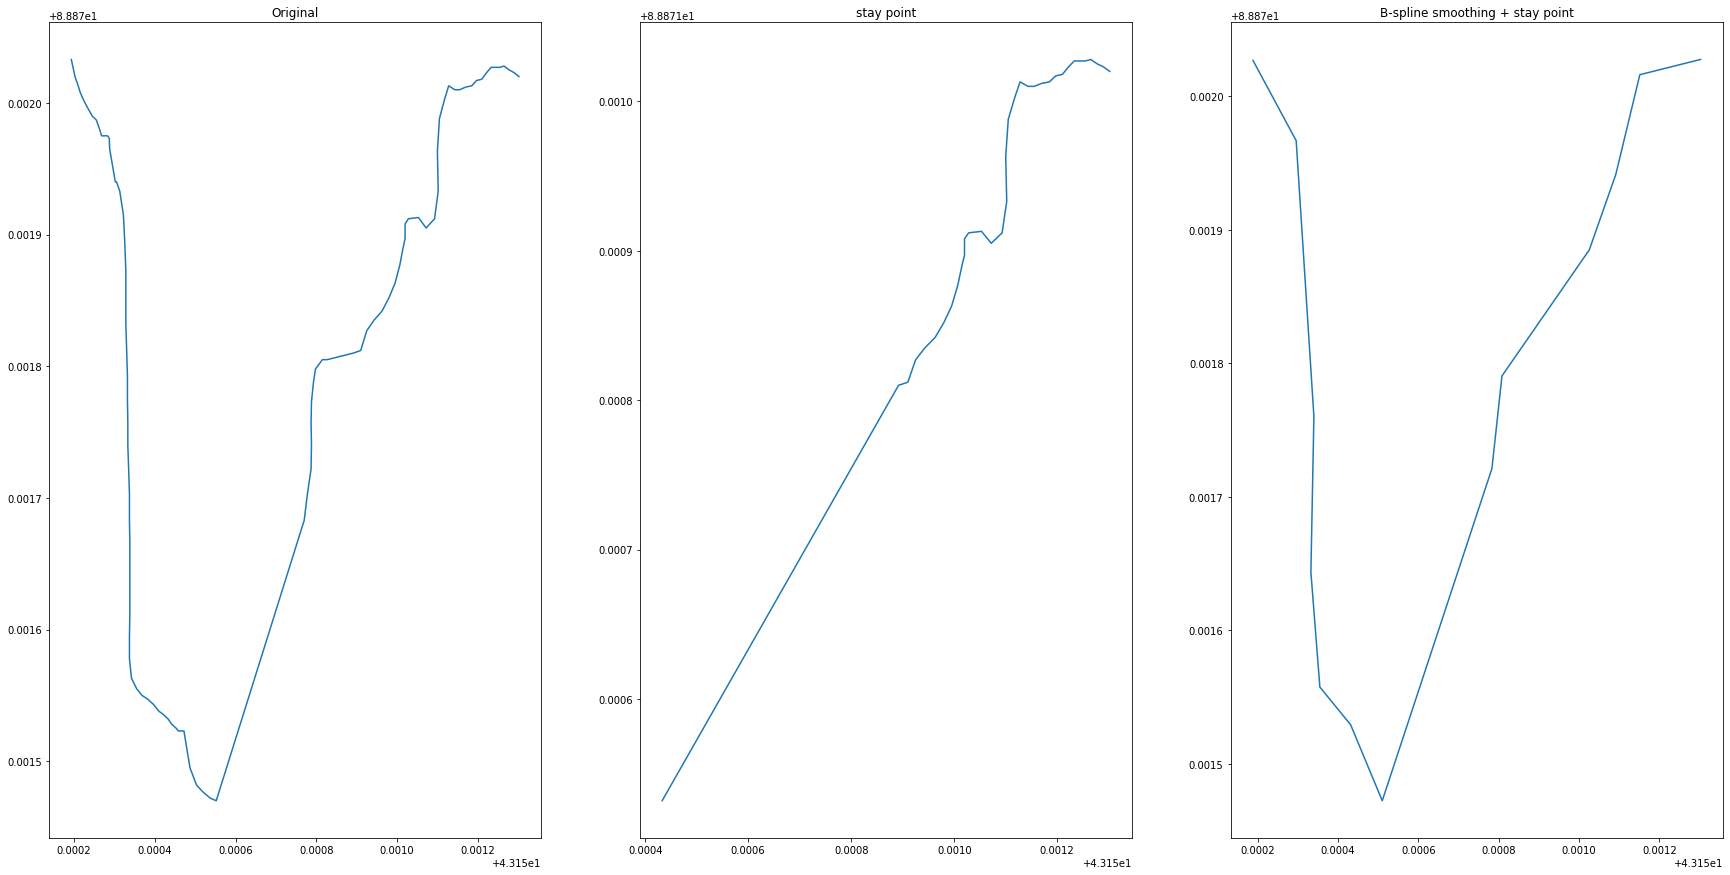

In [55]:
plotComparePlot(original_path_list,SPmodified_path_list,Bsmooth_path_list)

# Script used for generating smoothed plot and save figs

c:\users\szell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


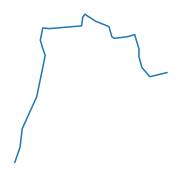

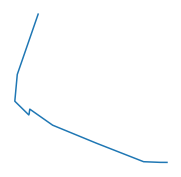

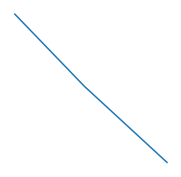

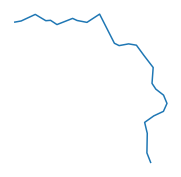

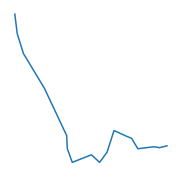

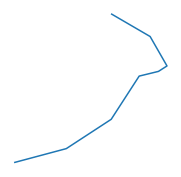

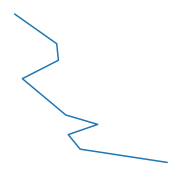

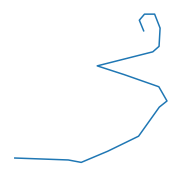

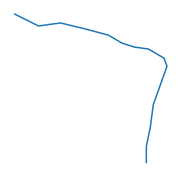

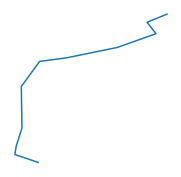

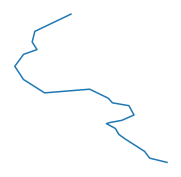

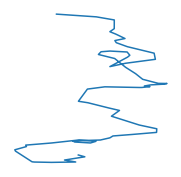

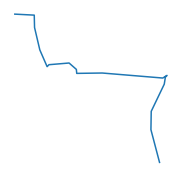

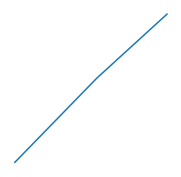

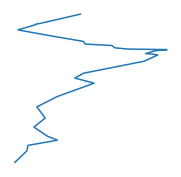

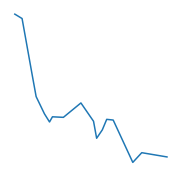

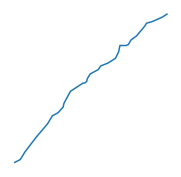

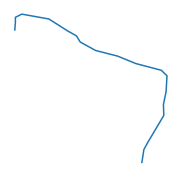

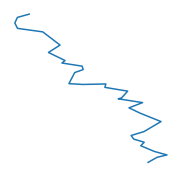

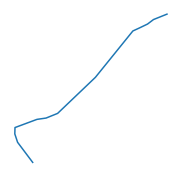

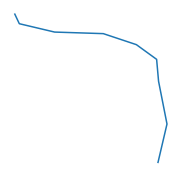

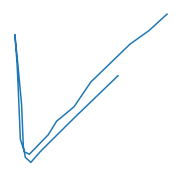

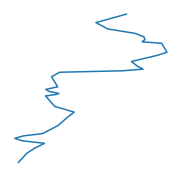

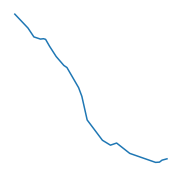

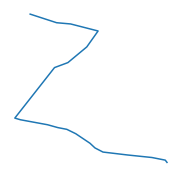

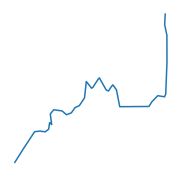

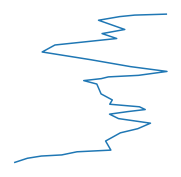

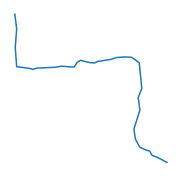

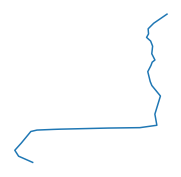

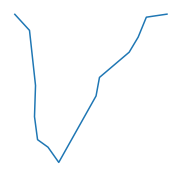

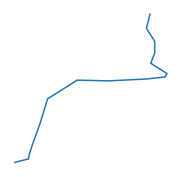

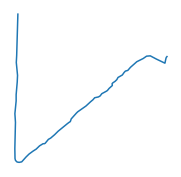

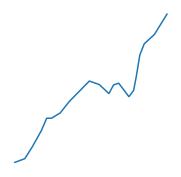

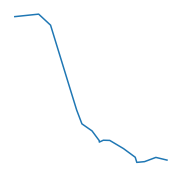

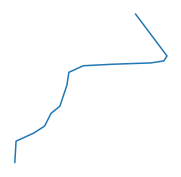

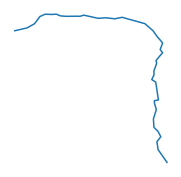

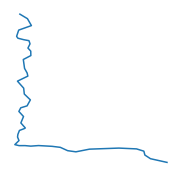

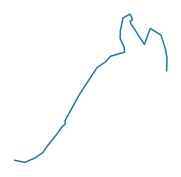

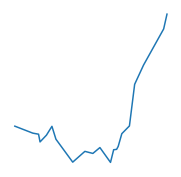

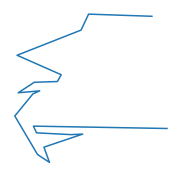

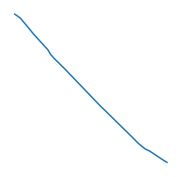

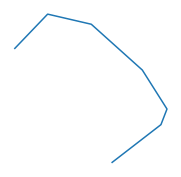

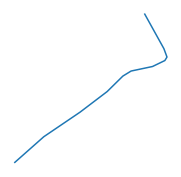

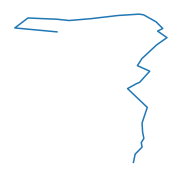

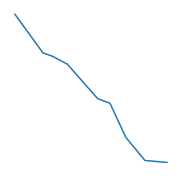

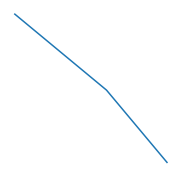

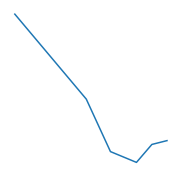

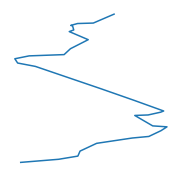

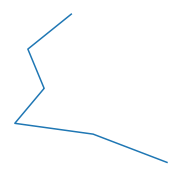

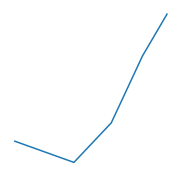

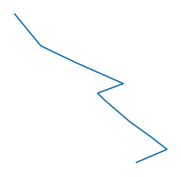

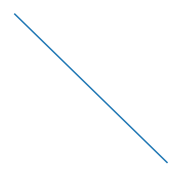

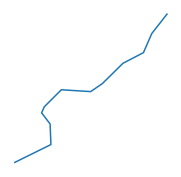

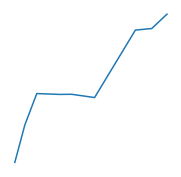

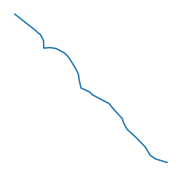

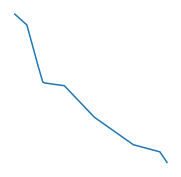

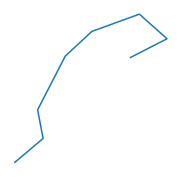

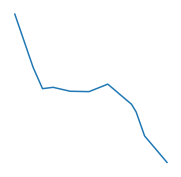

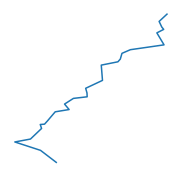

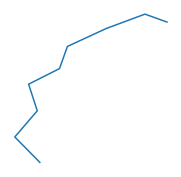

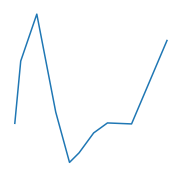

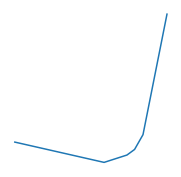

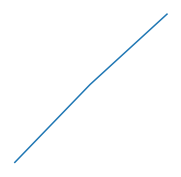

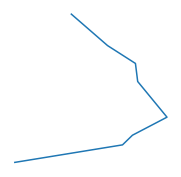

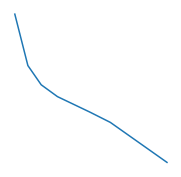

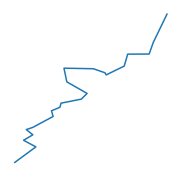

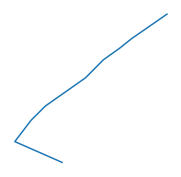

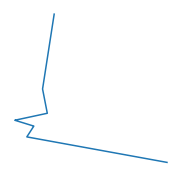

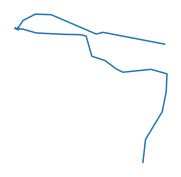

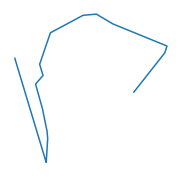

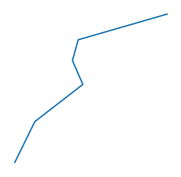

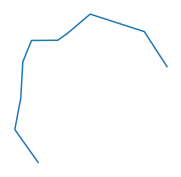

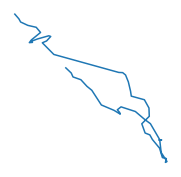

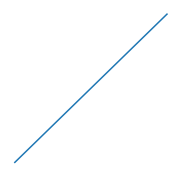

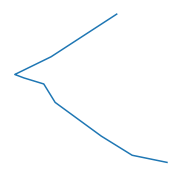

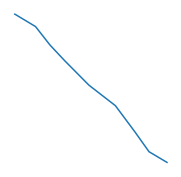

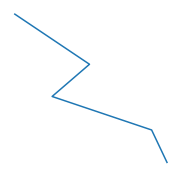

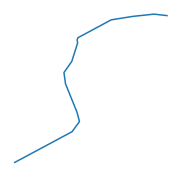

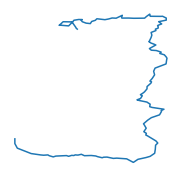

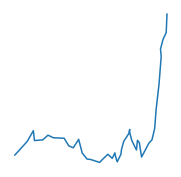

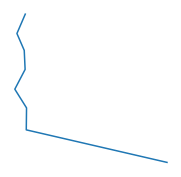

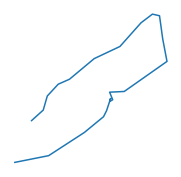

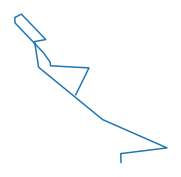

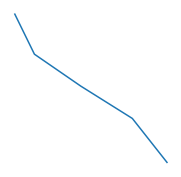

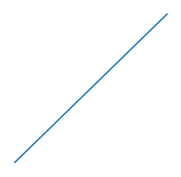

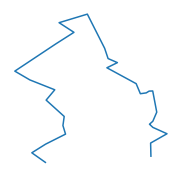

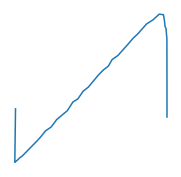

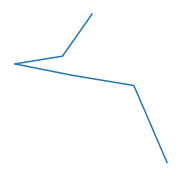

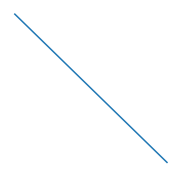

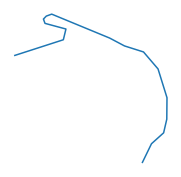

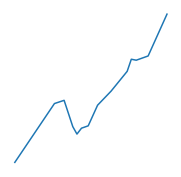

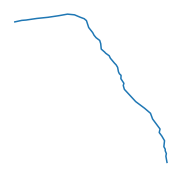

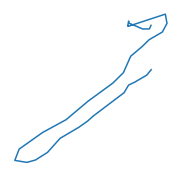

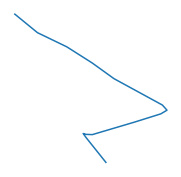

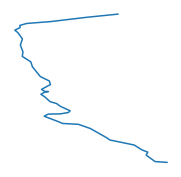

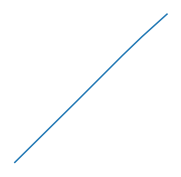

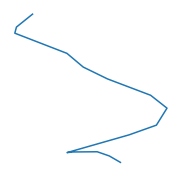

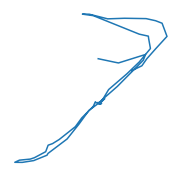

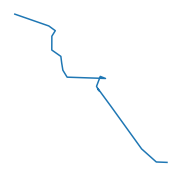

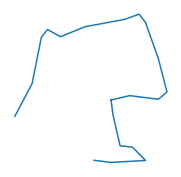

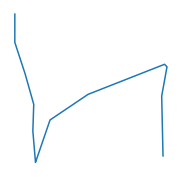

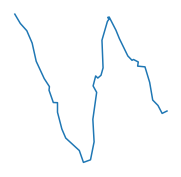

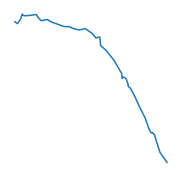

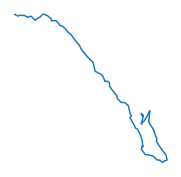

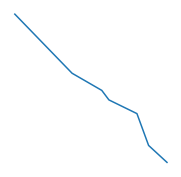

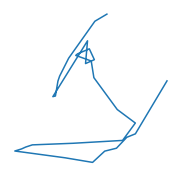

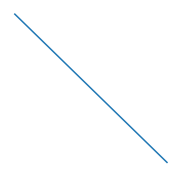

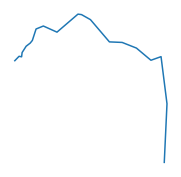

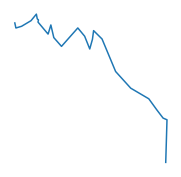

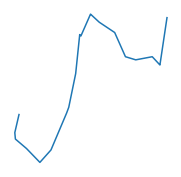

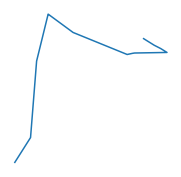

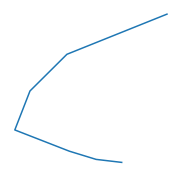

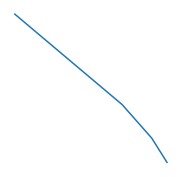

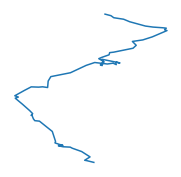

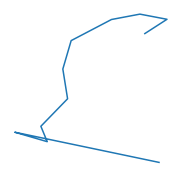

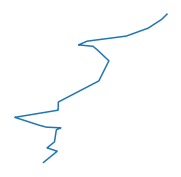

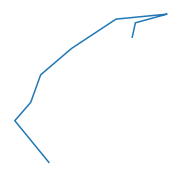

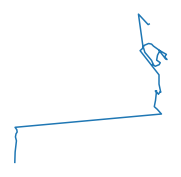

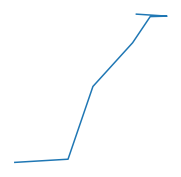

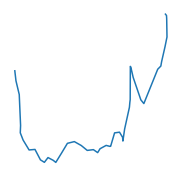

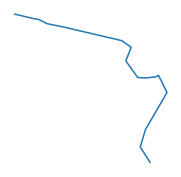

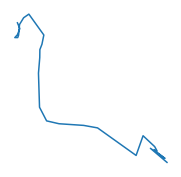

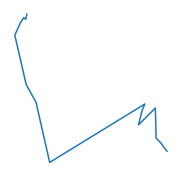

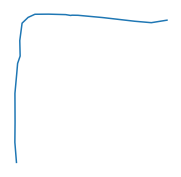

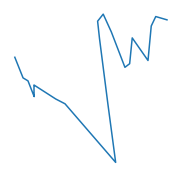

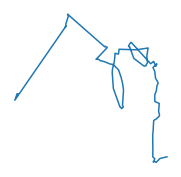

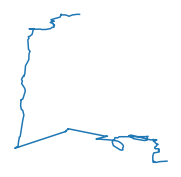

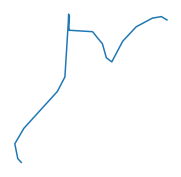

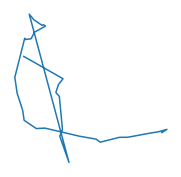

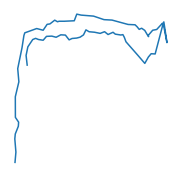

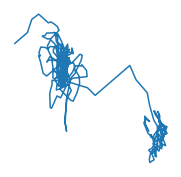

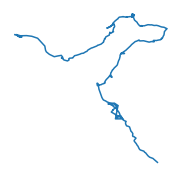

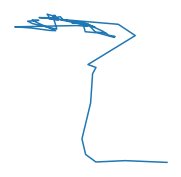

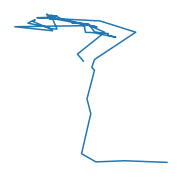

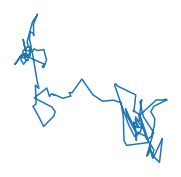

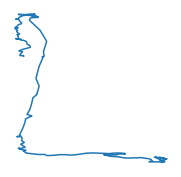

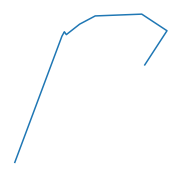

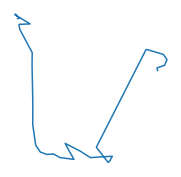

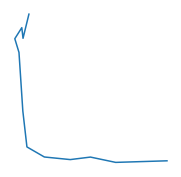

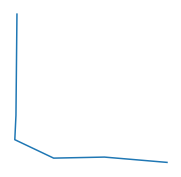

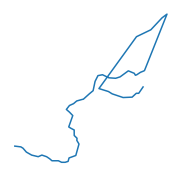

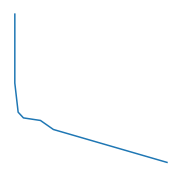

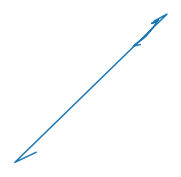

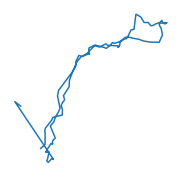

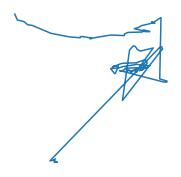

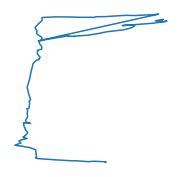

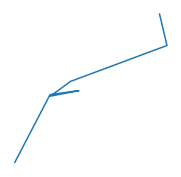

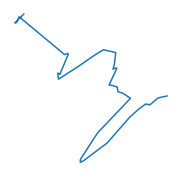

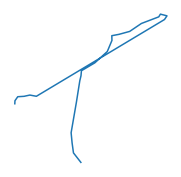

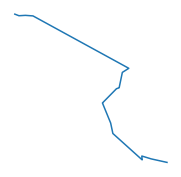

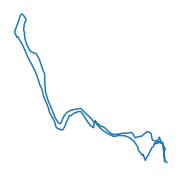

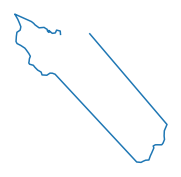

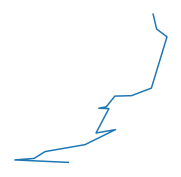

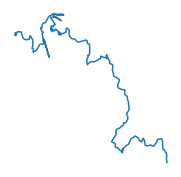

In [53]:
working_dir = os.getcwd() + "\Preprocessed-Users-Data\\"

for folder in os.listdir(working_dir): #for each user
# for folder in ['user_20','user_21','user_52']:
    
    THE_PATH = working_dir + folder+"\\"
    if (len(os.listdir(THE_PATH))  != 0): #ignore empty user folder
        
        
        for file in os.listdir(THE_PATH):
            data = read_files(working_dir + folder+"\\"+file)
            output = getStayPoint(data)
            
            #remove stay point clusters
            original_path_list = getOriginalPath(data)
#             SPmodified_path_list = smoothing(output,original_path_list)
            Bsmooth_path_list = BSplineSmoothing(original_path_list)
            
            #plot trajectory and save
            save_plots_here = './Figs/Smoothed2/'
            
            trip_id = file.split(".")[0]
            plot_trajectory(Bsmooth_path_list, folder, trip_id, save_plots_here)
            
                         
    